In [1]:
import pandas as pd
import numpy as np

In [2]:
!git clone https://github.com/samoletpanfilov/reinforcement_task.git

fatal: destination path 'reinforcement_task' already exists and is not an empty directory.


In [3]:
train = pd.read_excel('reinforcement_task/data/train.xlsx')
test = pd.read_excel('reinforcement_task/data/test.xlsx')
LME = pd.read_excel('reinforcement_task/data/Индекс LME.xlsx')
CHMF = pd.read_csv('reinforcement_task/data/CHMF Акции.csv')
MAGN = pd.read_csv('reinforcement_task/data/MAGN Акции.csv')
NLMK = pd.read_csv('reinforcement_task/data/NLMK Акции.csv')
trucking = pd.read_excel('reinforcement_task/data/Грузоперевозки.xlsx')
stock = pd.read_excel('reinforcement_task/data/Цены на сырье.xlsx')
build_materials = pd.read_excel('reinforcement_task/data/Данные рынка стройматериалов.xlsx')
macro = pd.read_excel('reinforcement_task/data/Макропоказатели.xlsx')
indexes = pd.read_excel('reinforcement_task/data/Показатели рынка металла.xlsx')
fuel = pd.read_excel('reinforcement_task/data/Топливо.xlsx')

# train + feature

In [4]:
train.rename(columns={'Цена на арматуру': 'y'}, inplace=True)

In [5]:
CHMF['Date'] = pd.to_datetime(CHMF['Date'], format = '%m/%d/%Y')

In [6]:
CHMF

,Date,Price,Open,High,Low,Vol.,Change %
0,2023-03-31,"1,043.20","1,061.00","1,061.00","1,042.00",571.72K,-1.68%
1,2023-03-30,"1,061.00","1,074.60","1,084.80","1,058.00",1.30M,-1.27%
2,2023-03-29,"1,074.60","1,040.60","1,078.40","1,035.40",1.79M,3.53%
3,2023-03-28,"1,038.00","1,041.40","1,044.00","1,033.00",269.09K,-0.17%
4,2023-03-27,"1,039.80","1,036.20","1,042.60","1,032.20",410.74K,0.50%
...,...,...,...,...,...,...,...
1049,2019-01-10,970.00,972.50,973.40,958.60,725.45K,-0.27%
1050,2019-01-09,972.60,953.10,973.50,950.00,1.03M,2.09%
1051,2019-01-08,952.70,952.00,960.00,941.30,565.63K,0.32%
1052,2019-01-04,949.70,934.00,949.70,931.10,335.53K,1.66%


In [7]:
CHMF['Price']=CHMF['Price'].apply(lambda x: x.replace(',','')).astype(float)
CHMF['Open']=CHMF['Open'].apply(lambda x: x.replace(',','')).astype(float)
CHMF['High']=CHMF['High'].apply(lambda x: x.replace(',','')).astype(float)
CHMF['Low']=CHMF['Low'].apply(lambda x: x.replace(',','')).astype(float)
CHMF['Change %']=CHMF['Change %'].apply(lambda x: x.replace('%','')).astype(float)
CHMF['Vol.'].fillna('2.67M',inplace=True) # замена пропуска предыдущим значением
CHMF['Vol.']=CHMF['Vol.'].apply(lambda x: float(x.replace('K',''))*1000 if 'K' in x else float(x.replace('M',''))*1000000)
CHMF = CHMF.rename({'Date':'dt'}, axis=1)

In [8]:
CHMF = CHMF[::-1]

In [9]:
train_CHMF = pd.merge_asof(train, CHMF, on='dt')

In [10]:
MAGN = MAGN.rename(columns={'Дата': 'Date',
                    'Цена': 'Price',
                    'Откр.': 'Open', 'Макс.': 'High', 'Мин.':'Low', 'Объём': 'Vol.', 'Изм. %':'Change %'})

In [11]:
MAGN['Date'] = pd.to_datetime(MAGN['Date'], format = '%d.%m.%Y')

In [12]:
MAGN['Price']=MAGN['Price'].apply(lambda x: x.replace(',','.')).astype(float)
MAGN['Open']=MAGN['Open'].apply(lambda x: x.replace(',','.')).astype(float)
MAGN['High']=MAGN['High'].apply(lambda x: x.replace(',','.')).astype(float)
MAGN['Low']=MAGN['Low'].apply(lambda x: x.replace(',','.')).astype(float)
MAGN['Change %']=MAGN['Change %'].apply(lambda x: x.replace('%','').replace(',','.')).astype(float)
MAGN['Vol.']=MAGN['Vol.'].apply(lambda x: float(x.replace('K','').replace(',', '.'))*1000 if 'K' in x else float(x.replace('M','').replace(',', '.'))*1000000)
MAGN = MAGN.rename({'Date':'dt'}, axis=1)
MAGN = MAGN[::-1]

In [13]:
train_MAGN = pd.merge_asof(train, MAGN, on='dt')

In [14]:
NLMK['Date'] = pd.to_datetime(NLMK['Date'], format = '%m/%d/%Y')

In [15]:
NLMK['Change %']=NLMK['Change %'].apply(lambda x: x.replace('%','').replace(',','.')).astype(float)
NLMK['Vol.']=NLMK['Vol.'].apply(lambda x: float(x.replace('K','').replace(',', '.'))*1000 if 'K' in x else float(x.replace('M','').replace(',', '.'))*1000000)
NLMK = NLMK.rename({'Date':'dt'}, axis=1)
NLMK = NLMK[::-1]

In [16]:
NLMK

,dt,Price,Open,High,Low,Vol.,Change %
1052,2019-01-03,157.34,155.86,157.34,154.80,2900000.0,-0.05
1051,2019-01-04,155.68,156.80,157.46,154.80,2910000.0,-1.06
1050,2019-01-08,150.12,150.98,151.34,149.64,3120000.0,-3.57
1049,2019-01-09,153.78,150.36,154.46,150.08,4030000.0,2.44
1048,2019-01-10,154.12,153.52,154.12,152.26,1960000.0,0.22
...,...,...,...,...,...,...,...
4,2023-03-27,128.18,127.00,128.42,126.86,2810000.0,1.33
3,2023-03-28,127.54,128.58,128.94,126.56,2270000.0,-0.50
2,2023-03-29,131.84,128.00,134.44,127.10,10370000.0,3.37
1,2023-03-30,130.60,132.30,133.44,129.80,4850000.0,-0.94


In [17]:
train_NLMK = pd.merge_asof(train, NLMK, on='dt')

In [18]:
train_trucking = pd.merge_asof(train, trucking, on='dt')

In [19]:
train_build_materials = pd.merge_asof(train, build_materials, on='dt')

In [20]:
macro = macro.drop('Базовый индекс потребительских цен на товары и услуги', axis=1)
macro = macro.fillna(method='backfill')
train_macro = pd.merge_asof(train, macro, on='dt')

In [21]:
LME = LME.iloc[:-1].rename({'дата': 'dt', 'цена': 'LME'}, axis=1)
train_LME = pd.merge_asof(train, LME, on='dt')

In [22]:
fuel = fuel.rename(columns={'Цена на бензин': 'gas',
                    'Цена на дт': 'diesel'})
train_fuel = pd.merge_asof(train, fuel, on='dt')
train_fuel.fillna(method='backfill', inplace=True)

In [23]:
train_indexes = pd.merge_asof(train, indexes, on='dt')

In [24]:
train_stock = pd.merge_asof(train, stock.fillna(method='bfill'), on='dt')

In [25]:
train = train.merge(train_LME, how='left')
train = train.merge(train_macro, how='left')
train = train.merge(train_build_materials, how='left')
train = train.merge(train_NLMK, how='left')
train = train.merge(train_MAGN, how='left')
train = train.merge(train_CHMF, how='left')
train = train.merge(train_fuel, how='left')
train = train.merge(train_trucking, how='left')
train = train.merge(train_indexes, how='left')
train = train.merge(train_stock, how='left')

# Feature's importance

In [26]:
train_feat = pd.DataFrame(train.dt, columns=['dt'])

**train_CHMF**

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = train_CHMF.dropna().drop(['y', 'dt'], axis=1)
y = train_CHMF.dropna()['y']

ss = StandardScaler()
X_scaled = ss.fit_transform(X)

In [28]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_scaled, y)
importances = pd.DataFrame(data={
    'Attribute': X.columns,
    'Importance': model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

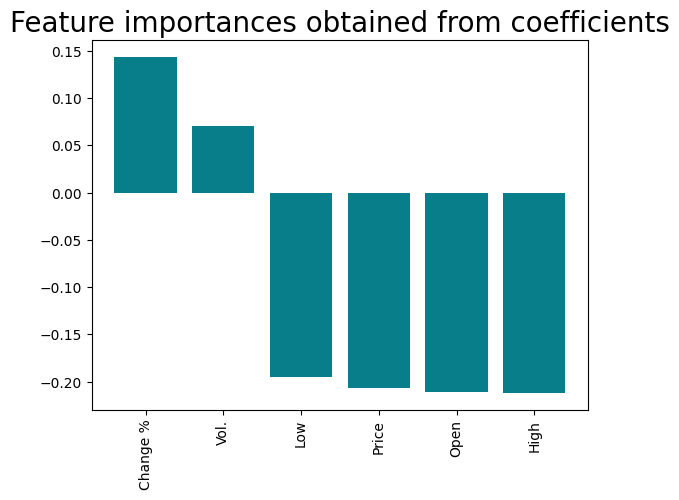

In [29]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

**train_MAGN**

In [30]:
X = train_MAGN.dropna().drop(['y', 'dt'], axis=1)
y = train_MAGN.dropna()['y']

ss = StandardScaler()
X_scaled = ss.fit_transform(X)

In [31]:
model = LogisticRegression()
model.fit(X_scaled, y)
importances = pd.DataFrame(data={
    'Attribute': X.columns,
    'Importance': model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

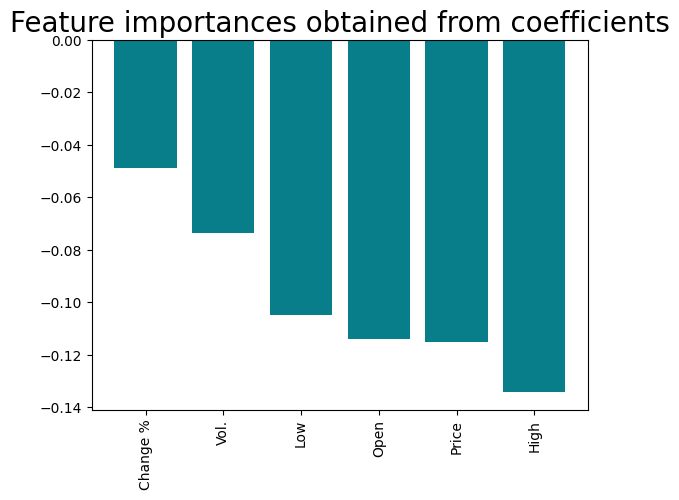

In [32]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

**train_NLMK**

In [33]:
X = train_NLMK.dropna().drop(['y', 'dt'], axis=1)
y = train_NLMK.dropna()['y']

ss = StandardScaler()
X_scaled = ss.fit_transform(X)

In [34]:
model = LogisticRegression()
model.fit(X_scaled, y)
importances = pd.DataFrame(data={
    'Attribute': X.columns,
    'Importance': model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

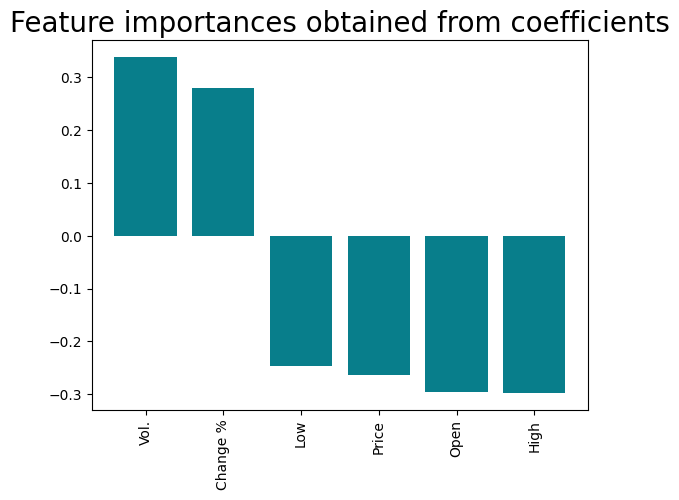

In [35]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [36]:
train_NLMK_feat = train_NLMK[['dt','Vol.','Open','High']]
train_NLMK_feat.rename(columns={'Vol.': 'NLMK_vol', 'Open': 'NLMK_open', 'High': 'NLMK_high'})
train_feat = pd.merge(train_feat, train_NLMK_feat, on='dt')

**train_trucking**

In [37]:
X = train_trucking.dropna().drop(['y', 'dt'], axis=1)
y = train_trucking.dropna()['y']

ss = StandardScaler()
X_scaled = ss.fit_transform(X)

In [38]:
model = LogisticRegression()
model.fit(X_scaled, y)
importances = pd.DataFrame(data={
    'Attribute': X.columns,
    'Importance': model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

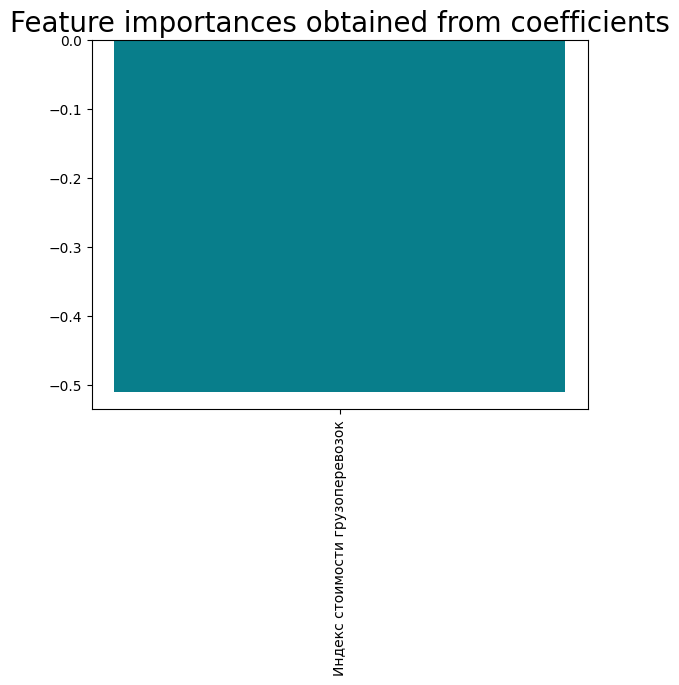

In [39]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [40]:
train_trucking_feat = train_trucking[['dt','Индекс стоимости грузоперевозок']]
train_trucking_feat.rename(columns={'Индекс стоимости грузоперевозок': 'train_trucking'})
train_feat = pd.merge(train_feat, train_trucking_feat, on='dt')

**train_build_materials**

In [41]:
X = train_build_materials.dropna().drop(['y', 'dt'], axis=1)
y = train_build_materials.dropna()['y']

ss = StandardScaler()
X_scaled = ss.fit_transform(X)

In [42]:
model = LogisticRegression()
model.fit(X_scaled, y)
importances = pd.DataFrame(data={
    'Attribute': X.columns,
    'Importance': model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

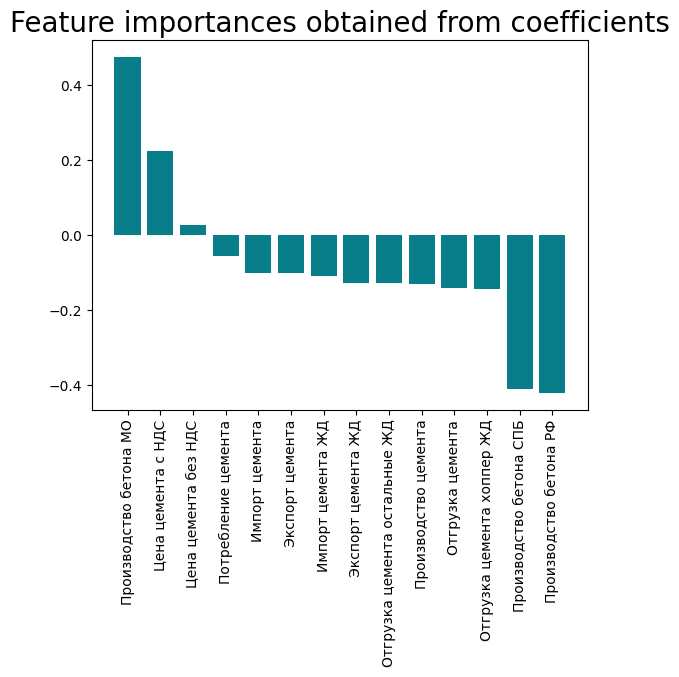

In [43]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [44]:
train_build_materials_feat = train_build_materials[['dt','Производство бетона МО', 'Производство бетона СПБ', 'Производство бетона РФ']]
# train_trucking_feat.rename(columns={'Индекс стоимости грузоперевозок': 'train_trucking'})
train_feat = pd.merge(train_feat,train_build_materials_feat, on='dt')

**train_macro**

In [45]:
X = train_macro.dropna().drop(['y', 'dt'], axis=1)
y = train_macro.dropna()['y']

ss = StandardScaler()
X_scaled = ss.fit_transform(X)

In [46]:
model = LogisticRegression()
model.fit(X_scaled, y)
importances = pd.DataFrame(data={
    'Attribute': X.columns,
    'Importance': model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

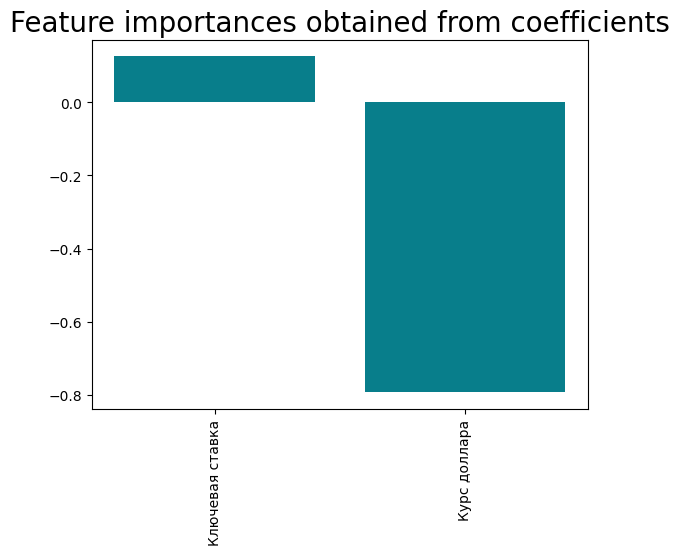

In [47]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [48]:
train_macro_feat = train_macro[['dt','Курс доллара']]
# train_macro_feat.rename(columns={'Индекс стоимости грузоперевозок': 'train_trucking'})
train_feat = pd.merge(train_feat, train_macro_feat, on='dt')

**train_LME**

In [49]:
X = train_LME.dropna().drop(['y', 'dt'], axis=1)
y = train_LME.dropna()['y']

ss = StandardScaler()
X_scaled = ss.fit_transform(X)

In [50]:
model = LogisticRegression()
model.fit(X_scaled, y)
importances = pd.DataFrame(data={
    'Attribute': X.columns,
    'Importance': model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

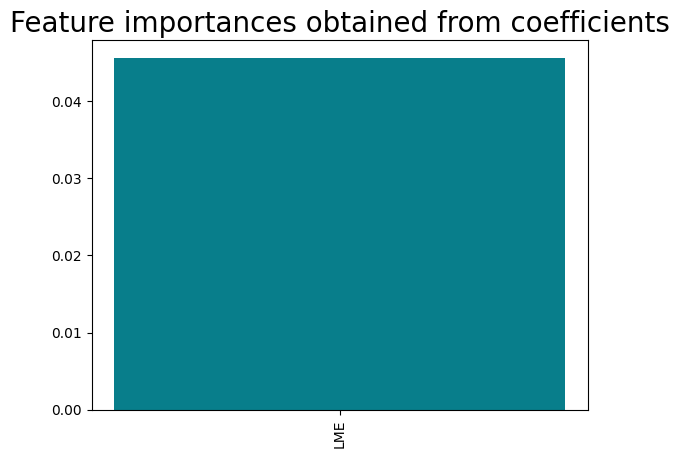

In [51]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

**train_fuel**

In [52]:
X = train_fuel.dropna().drop(['y', 'dt'], axis=1)
y = train_fuel.dropna()['y']

ss = StandardScaler()
X_scaled = ss.fit_transform(X)

In [53]:
model = LogisticRegression()
model.fit(X_scaled, y)
importances = pd.DataFrame(data={
    'Attribute': X.columns,
    'Importance': model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

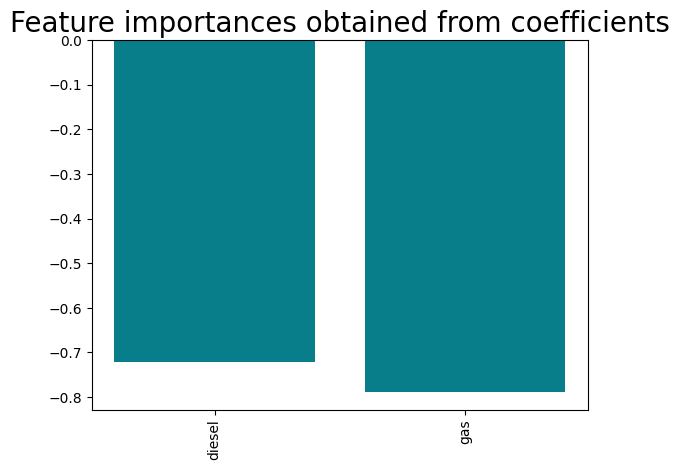

In [54]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [55]:
train_fuel_feat = train_fuel[['dt','diesel','gas']]
# train_macro_feat.rename(columns={'Индекс стоимости грузоперевозок': 'train_trucking'})
train_feat = pd.merge(train_feat, train_fuel_feat, on='dt')

**train_indexes**

In [56]:
X = train_indexes.dropna().drop(['y', 'dt'], axis=1)
y = train_indexes.dropna()['y']

ss = StandardScaler()
X_scaled = ss.fit_transform(X)

In [57]:
model = LogisticRegression()
model.fit(X_scaled, y)
importances = pd.DataFrame(data={
    'Attribute': X.columns,
    'Importance': model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


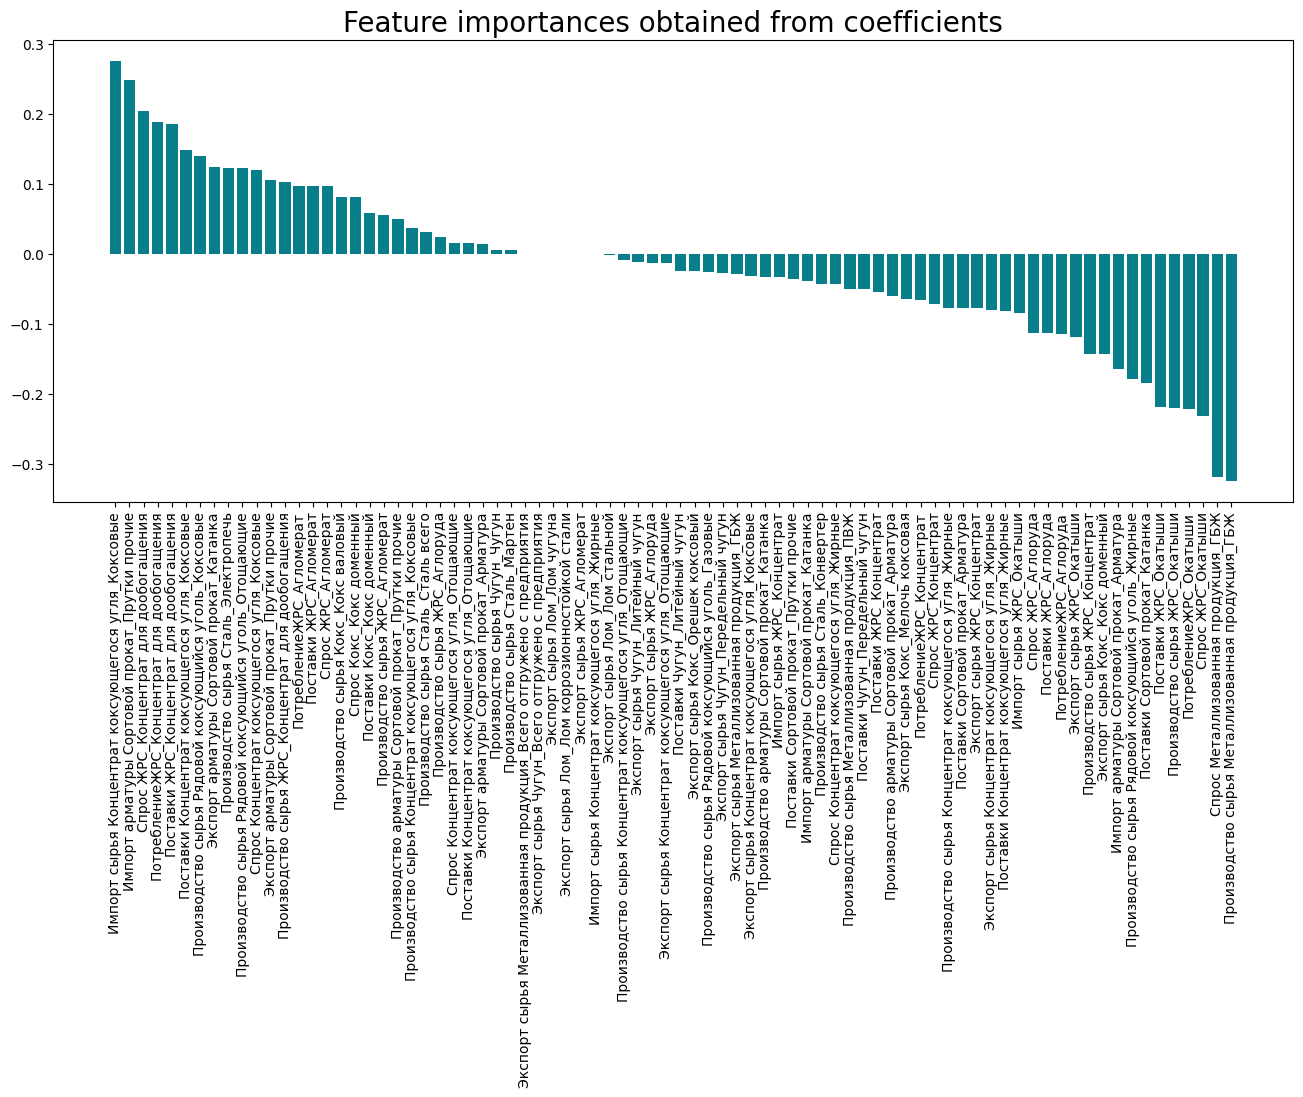

In [58]:
fig = plt.figure(figsize=(16,6))
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [59]:
train_indexes_feat = train_indexes[['dt','Спрос Металлизованная продукция_ГБЖ','Производство сырья Металлизованная продукция_ГБЖ']]
# train_macro_feat.rename(columns={'Индекс стоимости грузоперевозок': 'train_trucking'})
train_feat = pd.merge(train_feat, train_indexes_feat, on='dt')

**train_stock**

In [60]:
X = train_stock.fillna(method='bfill').drop(['y', 'dt'], axis=1)
y = train_stock.fillna(method='bfill')['y']

ss = StandardScaler()
X_scaled = ss.fit_transform(X)

In [61]:
model = LogisticRegression()
model.fit(X_scaled , y)
importances = pd.DataFrame(data={
    'Attribute': X.columns,
    'Importance': model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


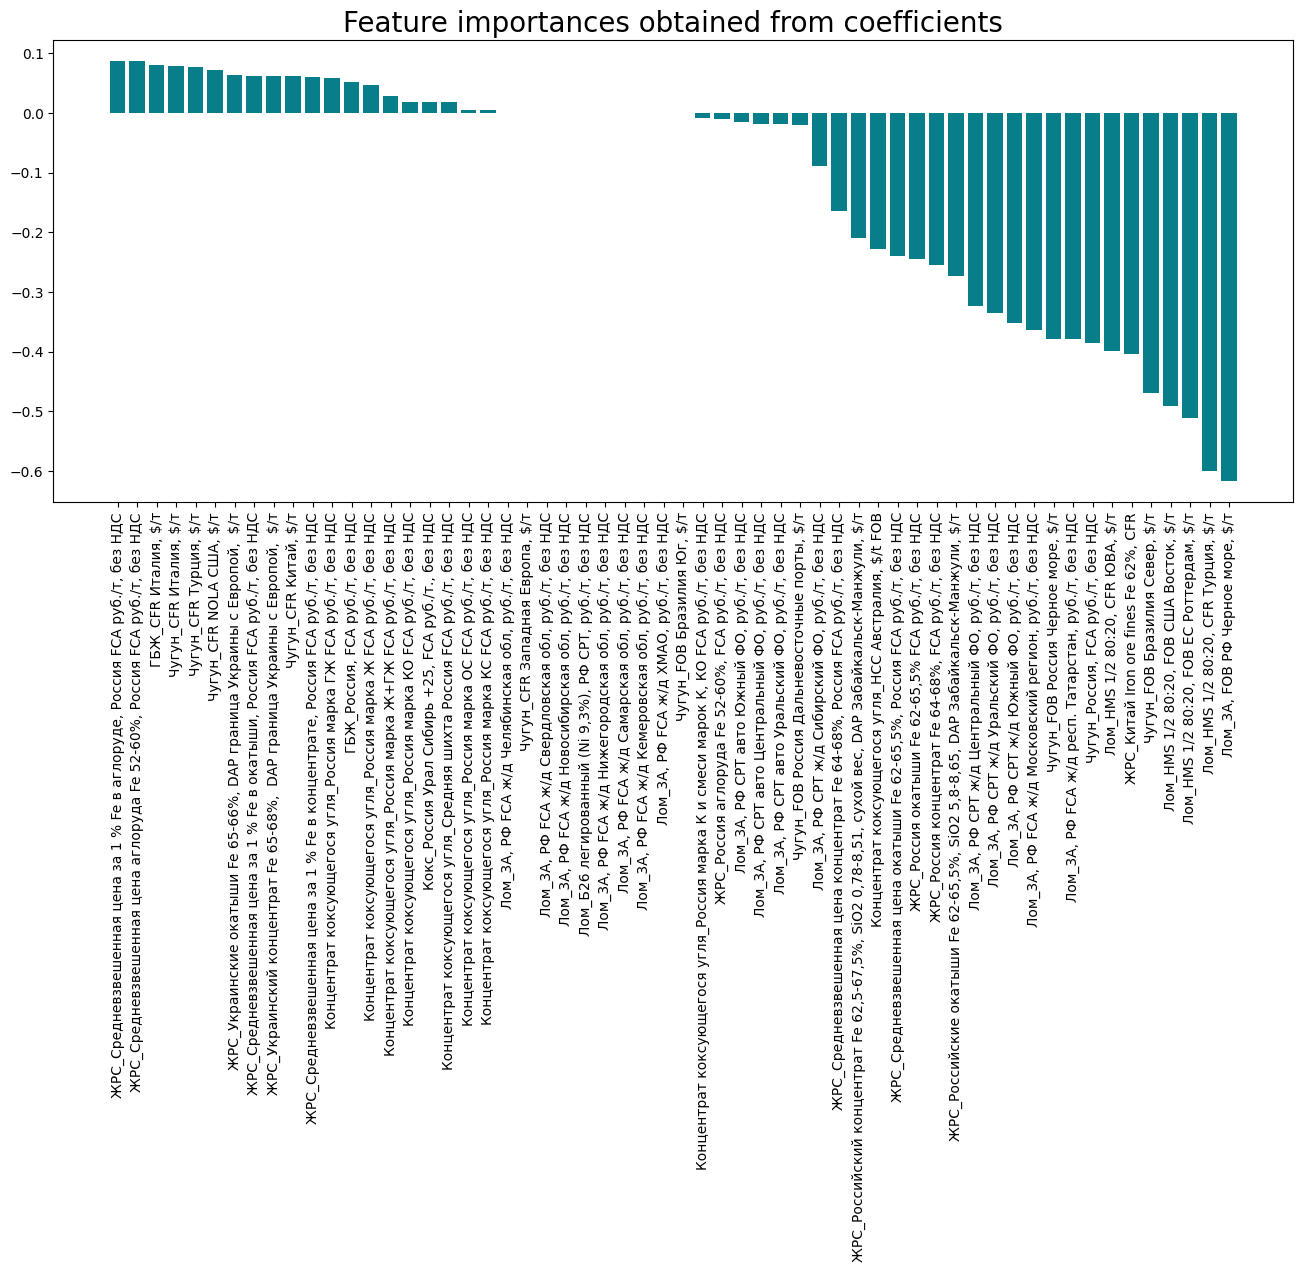

In [62]:
fig = plt.figure(figsize=(16,6))
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [63]:
train_stock_feat = train_stock[['dt','Чугун_FOB Бразилия Север, $/т','Лом_HMS 1/2 80:20, FOB США Восток, $/т']]
# train_macro_feat.rename(columns={'Индекс стоимости грузоперевозок': 'train_trucking'})
train_feat = pd.merge(train_feat, train_stock_feat, on='dt')

**FULL TRAIN FEATURES**

In [64]:
X = train.dropna().drop(['y', 'dt'], axis=1)
y = train.dropna()['y']

ss = StandardScaler()
X_scaled = ss.fit_transform(X)

In [65]:
model = LogisticRegression()
model.fit(X_scaled, y)
importances = pd.DataFrame(data={
    'Attribute': X.columns,
    'Importance': model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


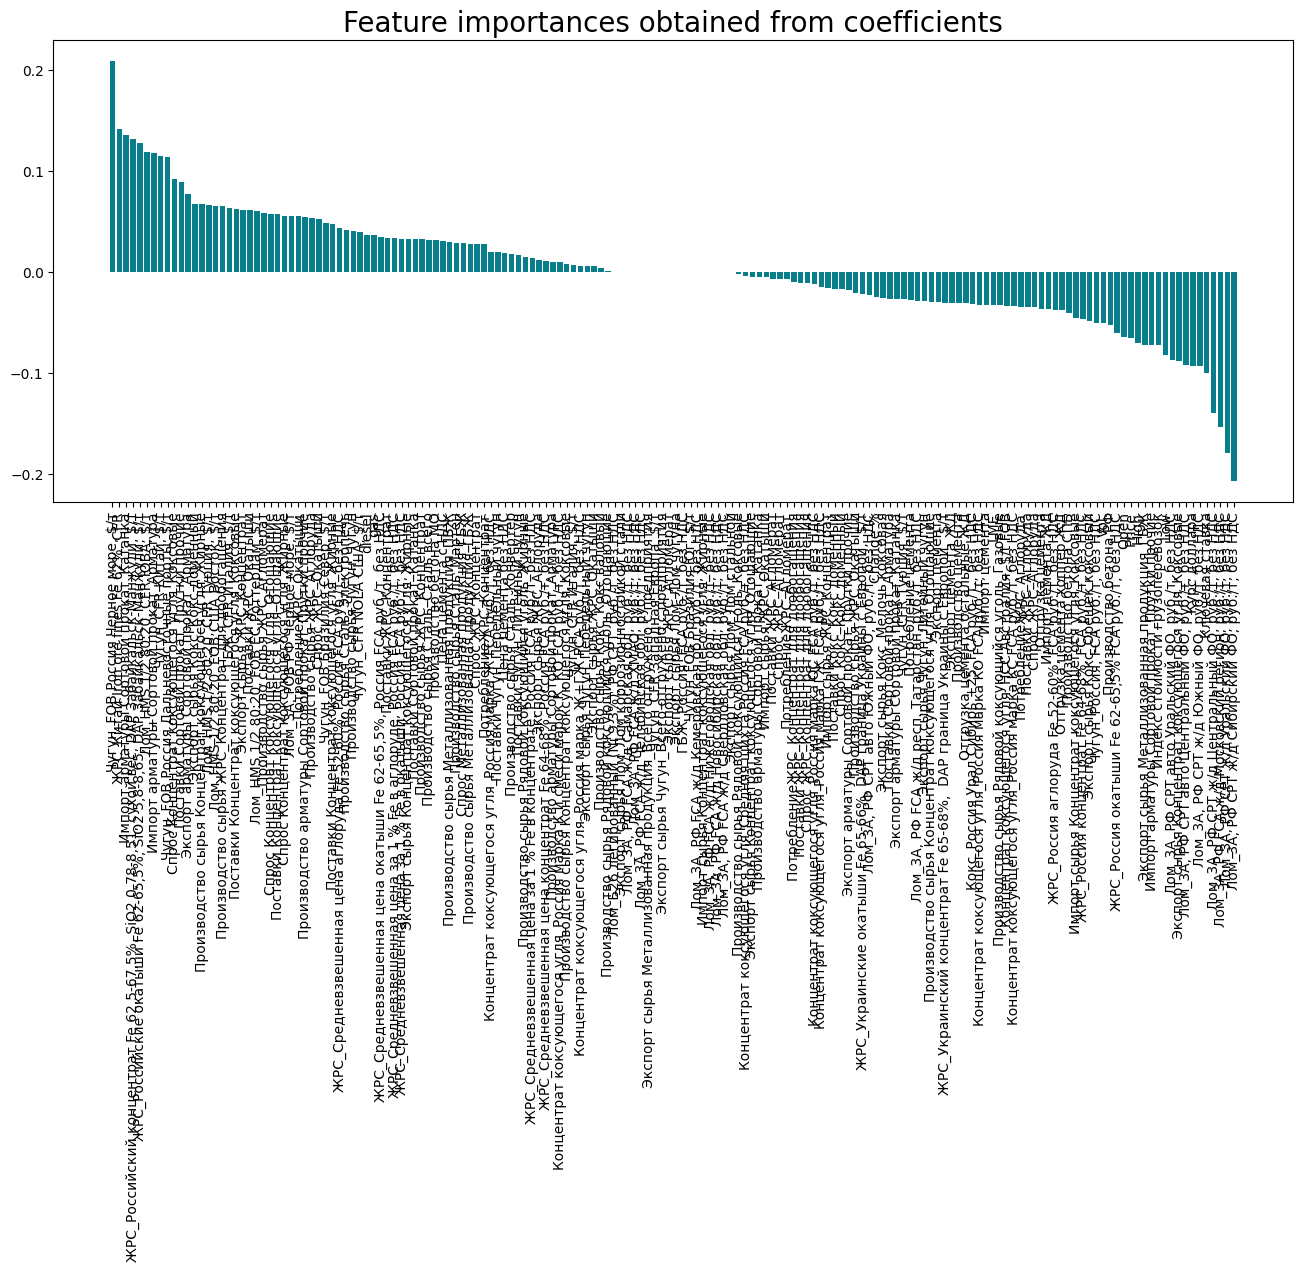

In [66]:
fig = plt.figure(figsize=(16, 6))

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')

plt.show()

# Тренировочный датасет train_feat со значимыми фичами

In [67]:
train_feat.head()

,dt,Vol.,Open,High,Индекс стоимости грузоперевозок,Производство бетона МО,Производство бетона СПБ,Производство бетона РФ,Курс доллара,diesel,gas,Спрос Металлизованная продукция_ГБЖ,Производство сырья Металлизованная продукция_ГБЖ,"Чугун_FOB Бразилия Север, $/т","Лом_HMS 1/2 80:20, FOB США Восток, $/т"
0,2015-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.15,35.91,NaN,NaN,NaN,NaN
1,2015-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.15,35.91,NaN,NaN,NaN,NaN
2,2015-01-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.15,35.91,NaN,NaN,NaN,NaN
3,2015-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.15,35.91,NaN,NaN,NaN,NaN
4,2015-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.15,35.91,NaN,NaN,NaN,NaN


In [68]:
train_feat.isna().sum()

dt                                                    0
Vol.                                                209
Open                                                209
High                                                209
Индекс стоимости грузоперевозок                     140
Производство бетона МО                              330
Производство бетона СПБ                             330
Производство бетона РФ                              330
Курс доллара                                         56
diesel                                                0
gas                                                   0
Спрос Металлизованная продукция_ГБЖ                  65
Производство сырья Металлизованная продукция_ГБЖ     65
Чугун_FOB Бразилия Север, $/т                         5
Лом_HMS 1/2 80:20, FOB США Восток, $/т                5
dtype: int64

In [69]:
train_feat.fillna(method='backfill', inplace=True)

In [70]:
train_feat = pd.merge(train_feat, train[['dt','y']], on='dt')

In [71]:
train_feat.isna().sum()

dt                                                  0
Vol.                                                0
Open                                                0
High                                                0
Индекс стоимости грузоперевозок                     0
Производство бетона МО                              0
Производство бетона СПБ                             0
Производство бетона РФ                              0
Курс доллара                                        0
diesel                                              0
gas                                                 0
Спрос Металлизованная продукция_ГБЖ                 0
Производство сырья Металлизованная продукция_ГБЖ    0
Чугун_FOB Бразилия Север, $/т                       0
Лом_HMS 1/2 80:20, FOB США Восток, $/т              0
y                                                   0
dtype: int64

In [72]:
train_feat.head()

,dt,Vol.,Open,High,Индекс стоимости грузоперевозок,Производство бетона МО,Производство бетона СПБ,Производство бетона РФ,Курс доллара,diesel,gas,Спрос Металлизованная продукция_ГБЖ,Производство сырья Металлизованная продукция_ГБЖ,"Чугун_FOB Бразилия Север, $/т","Лом_HMS 1/2 80:20, FOB США Восток, $/т",y
0,2015-01-05,2910000.0,156.8,157.46,1000.0,223.405,198.589,1.919781,57.0463,36.15,35.91,39.0,243.0,338.0,221.0,32900
1,2015-01-12,2910000.0,156.8,157.46,1000.0,223.405,198.589,1.919781,57.0463,36.15,35.91,39.0,243.0,338.0,221.0,32500
2,2015-01-19,2910000.0,156.8,157.46,1000.0,223.405,198.589,1.919781,57.0463,36.15,35.91,39.0,243.0,338.0,221.0,32000
3,2015-01-26,2910000.0,156.8,157.46,1000.0,223.405,198.589,1.919781,57.0463,36.15,35.91,39.0,243.0,338.0,221.0,30700
4,2015-02-02,2910000.0,156.8,157.46,1000.0,223.405,198.589,1.919781,57.0463,36.15,35.91,39.0,243.0,338.0,221.0,30300


In [73]:
train_feat = train_feat.rename(columns=dict(zip(train_feat.columns, ['dt' if i==0 else f'feat_{i-1}' for i in range(len(train_feat.columns)-1)])))

In [74]:
train_feat

,dt,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,y
0,2015-01-05,2910000.0,156.80,157.46,1000.0,223.405,198.589,1.919781,57.0463,36.15,35.91,39.0,243.0,338.0,221.0,32900
1,2015-01-12,2910000.0,156.80,157.46,1000.0,223.405,198.589,1.919781,57.0463,36.15,35.91,39.0,243.0,338.0,221.0,32500
2,2015-01-19,2910000.0,156.80,157.46,1000.0,223.405,198.589,1.919781,57.0463,36.15,35.91,39.0,243.0,338.0,221.0,32000
3,2015-01-26,2910000.0,156.80,157.46,1000.0,223.405,198.589,1.919781,57.0463,36.15,35.91,39.0,243.0,338.0,221.0,30700
4,2015-02-02,2910000.0,156.80,157.46,1000.0,223.405,198.589,1.919781,57.0463,36.15,35.91,39.0,243.0,338.0,221.0,30300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,2022-08-01,10760000.0,131.94,136.36,1200.0,989.940,338.706,0.004034,62.0506,53.21,51.35,102.0,429.0,460.0,319.0,47500
396,2022-08-08,2960000.0,122.50,122.50,1198.0,989.940,338.706,0.004034,60.3164,53.21,51.35,102.0,429.0,455.0,325.0,49000
397,2022-08-15,2900000.0,117.68,117.96,1211.0,989.940,338.706,0.004034,61.3747,53.21,51.35,102.0,429.0,455.0,362.0,47500
398,2022-08-22,3280000.0,115.10,117.08,1230.0,989.940,338.706,0.004034,59.7419,53.21,51.35,102.0,429.0,450.0,366.0,46500


# Приступим к обучению модели

In [75]:
import itertools
%matplotlib inline
import plotly.offline as pyoff
import plotly.graph_objs as go
from sklearn import preprocessing
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from scipy.stats import boxcox
from scipy.special import inv_boxcox

# DARTS. Модель: RNN

In [76]:
!pip install darts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [77]:
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel
from darts.metrics import mape
from darts.datasets import TimeSeries

In [78]:
darts_train = train_feat[['dt','y']]
darts_test = test.rename(columns={'ds':'dt'})
darts_test = darts_test.drop('Цена на арматуру', axis=1)
darts_full = pd.concat([darts_train, darts_test])
past_covariates_train = train_feat.drop('y', axis=1)
darts_full.head()

,dt,y
0,2015-01-05,32900.0
1,2015-01-12,32500.0
2,2015-01-19,32000.0
3,2015-01-26,30700.0
4,2015-02-02,30300.0


Text(0.5, 1.0, 'All past covariates for train')

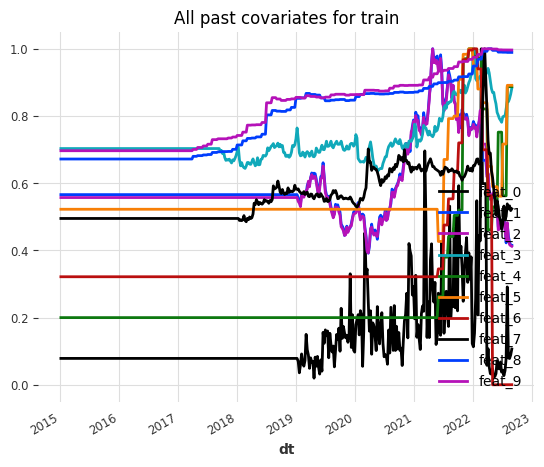

In [79]:
from darts import concatenate
from sklearn.preprocessing import MaxAbsScaler

# Read data:
series = TimeSeries.from_dataframe(darts_full.set_index('dt'))
train_series = TimeSeries.from_dataframe(darts_train.set_index('dt'))
test_series = TimeSeries.from_dataframe(darts_test)

# past covariates
covariates_series_0 = TimeSeries.from_dataframe(past_covariates_train[['dt','feat_0']].set_index('dt'))
covariates_series_1 = TimeSeries.from_dataframe(past_covariates_train[['dt','feat_1']].set_index('dt'))
covariates_series_2 = TimeSeries.from_dataframe(past_covariates_train[['dt','feat_2']].set_index('dt'))
covariates_series_3 = TimeSeries.from_dataframe(past_covariates_train[['dt','feat_3']].set_index('dt'))
covariates_series_4 = TimeSeries.from_dataframe(past_covariates_train[['dt','feat_4']].set_index('dt'))
covariates_series_5 = TimeSeries.from_dataframe(past_covariates_train[['dt','feat_5']].set_index('dt'))
covariates_series_6 = TimeSeries.from_dataframe(past_covariates_train[['dt','feat_6']].set_index('dt'))
covariates_series_7 = TimeSeries.from_dataframe(past_covariates_train[['dt','feat_7']].set_index('dt'))
covariates_series_8 = TimeSeries.from_dataframe(past_covariates_train[['dt','feat_8']].set_index('dt'))
covariates_series_9 = TimeSeries.from_dataframe(past_covariates_train[['dt','feat_9']].set_index('dt'))
covariates_series_10 = TimeSeries.from_dataframe(past_covariates_train[['dt','feat_10']].set_index('dt'))
covariates_series_11 = TimeSeries.from_dataframe(past_covariates_train[['dt','feat_11']].set_index('dt'))
covariates_series_12 = TimeSeries.from_dataframe(past_covariates_train[['dt','feat_12']].set_index('dt'))
covariates_series_13 = TimeSeries.from_dataframe(past_covariates_train[['dt','feat_13']].set_index('dt'))

all_covariates = covariates_series_0.stack(covariates_series_1)
all_covariates = all_covariates.stack(covariates_series_2)
all_covariates = all_covariates.stack(covariates_series_3)
all_covariates = all_covariates.stack(covariates_series_4)
all_covariates = all_covariates.stack(covariates_series_5)
all_covariates = all_covariates.stack(covariates_series_6)
all_covariates = all_covariates.stack(covariates_series_7)
all_covariates = all_covariates.stack(covariates_series_8)
all_covariates = all_covariates.stack(covariates_series_9)
all_covariates = all_covariates.stack(covariates_series_10)
all_covariates = all_covariates.stack(covariates_series_11)
all_covariates = all_covariates.stack(covariates_series_12)
all_covariates = all_covariates.stack(covariates_series_13)

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler(MaxAbsScaler())
train_transformed = transformer.fit_transform(train_series)
val_transformed = transformer.transform(test_series)
series_transformed = transformer.transform(series)
cov_transformer = Scaler(MaxAbsScaler())
all_covariates_scaled = cov_transformer.fit_transform(all_covariates)

# plot the covariates:
plt.figure()
all_covariates_scaled.plot()
plt.title("All past covariates for train")


# Darts: Модель Temporal Convolutional Networks

In [80]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.5 MB/s eta 0:00:00


In [81]:
from darts.models import TCNModel, BlockRNNModel
from darts.utils.likelihood_models import GaussianLikelihood

brnn_model = BlockRNNModel(
    model = 'LSTM',
    input_chunk_length=50,
    dropout=0.3,
    output_chunk_length=len(val_transformed),
    n_rnn_layers=10)

brnn_model.fit(train_transformed,
          past_covariates=all_covariates_scaled,
          epochs=300,
          verbose=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 51.0 K
4 | fc            | Sequential       | 728   
---------------------------------------------------
51.7 K    Trainable params
0         Non-trainable params
51.7 K    Total params
0.207     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.


BlockRNNModel(model=LSTM, hidden_dim=25, n_rnn_layers=10, hidden_fc_sizes=None, dropout=0.3, input_chunk_length=50, output_chunk_length=28)

In [82]:
forecast = brnn_model.predict(series=train_transformed, n=len(val_transformed))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

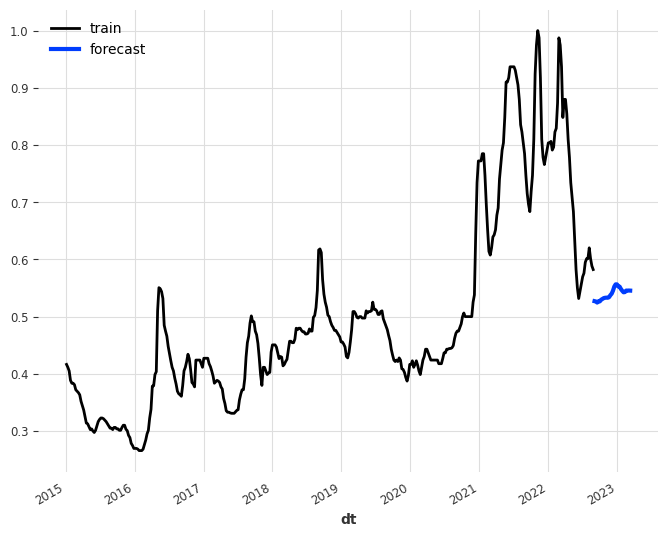

In [96]:
plt.figure(figsize=(8,6))
train_transformed.plot(lw=2, label='train')
# val_transformed.plot(lw=2, label='test')
forecast.plot(lw=3, label='forecast')

Метрика качества предскания модели

In [84]:
forecast_RNN = transformer.inverse_transform(forecast)

In [93]:
preds = forecast_RNN.all_values()
preds = [elem for sublist in preds for subsublist in sublist for elem in subsublist]
darts_test['pred'] = preds
darts_test['y'] = test['Цена на арматуру']
darts_test.head()

,dt,pred,y
time,,,
0,2022-09-05,41635.142331,46000
1,2022-09-12,41591.925644,46000
2,2022-09-19,41443.193747,46000
3,2022-09-26,41616.540763,45500
4,2022-10-03,41607.699955,45500


<Axes: xlabel='dt'>

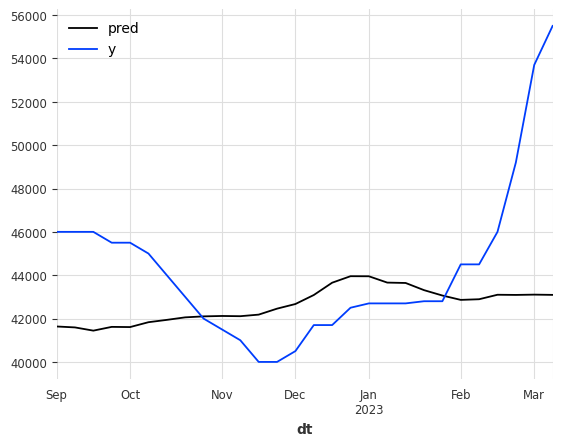

In [94]:
darts_test.plot(x='dt')

In [95]:
from sklearn.metrics import mean_squared_error

mean_squared_error(test['Цена на арматуру'], preds)


16091679.042390283

In [97]:
brnn_model.save('best')

# Переход к предсказанию необходимого объема закупки

In [98]:
def decision_prices(test):

    test = test.set_index('dt')
    tender_price = test['y']
    decision = test['Объем']
    start_date = test.index.min()
    end_date = test.index.max()

    _results = []
    _active_weeks = 0
    for report_date in pd.date_range(start_date, end_date, freq='W-MON'):
        if _active_weeks == 0:  # Пришла пора нового тендера
            _fixed_price = tender_price.loc[report_date]
            _active_weeks = int(decision.loc[report_date])
        _results.append(_fixed_price)
        _active_weeks += -1
    cost = sum(_results)
    return cost # Возвращаем затраты на периоде

In [99]:
def volume(df, name):
    price = df[name].values
    out = [0]*len(df)

    i = 0
    while i < len(df):
        i += 1
        count = 0
        for j in range(i+1, min(i+11, len(df))):
            count += 1
            if price[i] >= price[j]:
                out[i] = count
                i += count - 1
                count = 0
                break
        else:
            out[i] = min(10, len(df) - i)
            i += 9
            count = 0
    out[0] = 1
    df['Объем'] = out
    return df

In [100]:
decision_prices(volume(train, 'y'))

14738950

In [101]:
decision_prices(volume(darts_test, 'y'))

1192500

In [102]:
decision_prices(volume(darts_test, 'pred'))

1219000

In [103]:
darts_test

,dt,pred,y,Объем
time,,,,
0,2022-09-05,41635.142331,46000,1
1,2022-09-12,41591.925644,46000,1
2,2022-09-19,41443.193747,46000,10
3,2022-09-26,41616.540763,45500,0
4,2022-10-03,41607.699955,45500,0
5,2022-10-10,41832.078831,45000,0
6,2022-10-17,41939.746972,44000,0
7,2022-10-24,42056.124964,43000,0
8,2022-10-31,42101.133687,42000,0


In [104]:
darts_test = darts_test.rename(columns={'pred': "Цена на арматуру"})
darts_test.drop('y', axis=1).to_excel('submission.xlsx', index=False)